In [5]:
import warnings
import json
from cProfile import label
import pandas as pd
import lightgbm as lgb
import xgboost as xgb
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_curve,roc_auc_score,recall_score,precision_recall_curve,auc,precision_score,f1_score,class_likelihood_ratios
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.utils import resample,shuffle
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import re
from imblearn.over_sampling import RandomOverSampler
import shap
import time
import copy
#from svm-gpu import SVM
from IPython.display import display
import os
import joblib
from tqdm import trange
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout,Embedding,Conv1D,LSTM,MaxPooling1D,Bidirectional
from tensorflow.keras.regularizers import l2
from keras.optimizers import Adam
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
from sklearn.metrics import f1_score
from tensorflow.keras.utils import to_categorical
import random
import keras.backend as K
from keras.utils import plot_model



In [7]:
model = Sequential()
model.add(Embedding(input_dim=5, output_dim=5, input_length=40))
model.add(Conv1D(filters=320, kernel_size=12, activation='relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.1))
model.add(Bidirectional(LSTM(32, activation='relu')))
model.add(Dropout(0.1))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))
model.summary()
plot_model(model)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 40, 5)             25        
                                                                 
 conv1d_3 (Conv1D)           (None, 29, 320)           19520     
                                                                 
 dropout_12 (Dropout)        (None, 29, 320)           0         
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 14, 320)          0         
 1D)                                                             
                                                                 
 dropout_13 (Dropout)        (None, 14, 320)           0         
                                                                 
 bidirectional_3 (Bidirectio  (None, 64)               90368     
 nal)                                                 

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
if tf.test.gpu_device_name():
    print('GPU found')
else:
    print("No GPU found")

No GPU found


In [3]:
def plot_roc_curve(fper,tper,fper_up,tper_up,auc,auc_up,color_origin='orange',color_up='red'):
    '''
    for i in range(len(fper)):
        plt.plot(fper[i],tper[i],color='red')#,label='ROC,auc:'+'%.3f'%(sum(auc)/len(auc)))
        plt.plot(fper_up[i],tper_up[i],color = 'orange',linestyle = '--')#,label = 'ROC_up,auc:'+'%.3f'%(sum(auc_up)/len(auc_up)))
    '''
    ## plot the ROC region for orgin distribution 
    item_max = auc.index(max(auc))
    item_min = auc.index(min(auc))
    xfill = np.sort(np.concatenate([fper[item_max], fper[item_min]]))
    y1fill = np.interp(xfill, fper[item_max],tper[item_max])
    y2fill = np.interp(xfill, fper[item_min], tper[item_min])
    plt.plot(fper[item_max],tper[item_max],color = color_origin,linestyle='--', alpha=0.6)
    plt.plot(fper[item_min],tper[item_min],color = color_origin,linestyle='--',alpha=0.6)
    plt.plot(xfill,(y1fill+y2fill)/2,color = color_origin)
    plt.fill_between(xfill, y1fill, y2fill, interpolate=True, color=color_origin, alpha=0.5)
    ## plot the ROC region for upsampling distrubution
    item_up_max = auc_up.index(max(auc_up))
    item_up_min = auc_up.index(min(auc_up))
    xfill_up = np.sort(np.concatenate([fper_up[item_up_max], fper_up[item_up_min]]))
    y1fill_up = np.interp(xfill_up, fper_up[item_up_max],tper_up[item_up_max])
    y2fill_up = np.interp(xfill_up, fper_up[item_up_min], tper_up[item_up_min])
    plt.plot(fper_up[item_up_max],tper_up[item_up_max],color = color_up,linestyle='--',alpha=0.6)
    plt.plot(fper_up[item_up_min],tper_up[item_up_min],color = color_up,linestyle='--',alpha=0.6)
    plt.plot(xfill_up,(y1fill_up+y2fill_up)/2,color = color_up)
    plt.fill_between(xfill_up,y1fill_up,y2fill_up,interpolate=True,color =color_up,alpha = 0.15)

    plt.plot(1,1,color=color_origin,label='ROC,auc:'+'%.3f'%(sum(auc)/len(auc)))
    plt.plot(1,1,color = color_up,label = 'ROC_up,auc:'+'%.3f'%(sum(auc_up)/len(auc_up)))
    plt.plot([0,1],[0,1],color = 'green',linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend()
    plt.legend(loc='lower right')
    return(fper[item_max],tper[item_max],fper[item_min],tper[item_min],fper_up[item_up_max],tper_up[item_up_max],fper_up[item_up_min],tper_up[item_up_min],sum(auc)/len(auc),sum(auc_up)/len(auc_up))
def plot_prc_curve(precision,recall,precision_up,recall_up,auc,auc_up,color_origin='orange',color_up='red'):
    # plot the PR region for origin distribution
    item_max = auc.index(max(auc))
    item_min = auc.index(min(auc))
    print('origin_best:',item_max+1,'origin_min:',item_min+1)
    #print(len(recall[item_max]))
    ## 修正接近x軸為零時，會有(0,0)產生
    recall_min = list(recall[item_min][0:(len(recall[item_min]))])
    precision_min = list(precision[item_min][0:(len(recall[item_min]))])
    recall_max = list(recall[item_max][0:(len(recall[item_max]))])
    precision_max = list(precision[item_max][0:(len(recall[item_max]))])
    #繪圖(sort&concatenate是為了內插而產生的X點)
    xfill = np.sort(np.concatenate([recall_max, recall_min]))
    y1fill = np.interp(xfill, recall_max[::-1],precision_max[::-1]) #因為x為 1 -> 0 而非0->1，所以需要再使用np.interp的時候要先顛倒x和y，使其由小到大才能做內插
    y2fill = np.interp(xfill,recall_min[::-1], precision_min[::-1])#因為x為 1 -> 0 而非0->1，所以需要再使用np.interp的時候要先顛倒x和y，使其由小到大才能做內插
    plt.plot(recall_max,precision_max,color = color_origin,linestyle='--',alpha=0.6)
    plt.plot(recall_min,precision_min,color = color_origin,linestyle='--',alpha=0.6)
    plt.plot(xfill,(y1fill+y2fill)/2,color = color_origin)
    plt.fill_between(xfill, y2fill, y1fill,interpolate=True, alpha=0.5, color=color_origin)


    #print(*precision[item_max])
    #plot the PR region for upsampling distribution
    item_up_max = auc_up.index(max(auc_up))
    item_up_min = auc_up.index(min(auc_up))
    print('up_best:',item_up_max+1,'up_min:',item_up_min+1)
    #修正接近x軸為零時，會有(0,0)產生
    recall_min_up = list(recall_up[item_up_min][0:(len(recall_up[item_up_min]))])
    precision_min_up = list(precision_up[item_up_min][0:(len(recall_up[item_up_min]))])
    recall_max_up = list(recall_up[item_up_max][0:(len(recall_up[item_up_max]))])
    precision_max_up = list(precision_up[item_up_max][0:(len(recall_up[item_up_max]))])
    #繪圖(sort&concatenate是為了內插而產生的X點)
    xfill_up = np.sort(np.concatenate([recall_max_up, recall_min_up]))
    y1fill_up = np.interp(xfill_up, recall_max_up[::-1],precision_max_up[::-1])
    y2fill_up = np.interp(xfill_up, recall_min_up[::-1], precision_min_up[::-1])
    plt.plot(recall_max_up,precision_max_up,color = color_up,linestyle='--',alpha=0.6)
    plt.plot(recall_min_up,precision_min_up,color = color_up,linestyle='--',alpha=0.6)
    plt.plot(xfill_up,(y1fill_up+y2fill_up)/2,color = color_up)
    plt.fill_between(xfill_up,y1fill_up, y2fill_up, interpolate=True, alpha=0.5, color=color_up)

    '''
    for i in range(len(precision)):
        plt.plot(precision[i],recall[i],color='red')#,label='PRC{},auc:'.format(i+1)+'%.3f'%(auc[i])) 
        plt.plot(precision_up[i],recall_up[i],color = 'orange',linestyle = '--')#,label = 'PRC_up{},auc:'.format(i+1)+'%.3f'%(auc_up[i]))
    '''
    plt.plot(1,1,color = color_origin,label='PRC,auc(avg):'+'%.3f'%(sum(auc)/len(auc)))
    plt.plot(1,1,color = color_up,linestyle = '--',label = 'PRC_up,auc(avg):'+'%.3f'%(sum(auc_up)/len(auc_up)))
    #plt.scatter(0.925,0.05)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision Recall Curve')
    plt.legend()
    plt.legend(loc='lower left')
    return(recall_min,precision_min,recall_max,precision_max,recall_min_up,precision_min_up,recall_max_up,precision_max_up,sum(auc)/len(auc),sum(auc_up)/len(auc_up))

In [2]:
class StopTrainingCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        self.model.stop_training = True
        print('- Learning rate:', self.model.optimizer.learning_rate.numpy())
    def on_epoch_begin(self,epoch,logs=None):
        self.model.stop_training = False
stop_training_callback = StopTrainingCallback()
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [5]:
def lr_schedule(epoch, lr):
    decay_rate = 0.99
    decay_steps = 10000
    return lr * decay_rate**(epoch-1) #** (epoch / decay_steps)

In [7]:
def kfold_self(
    cv = 5,
    lr = 0.1,
    random_state  = 30,
    path = 'k_fold_train_validation_42',
    epoch = 10,
    model_save_path = None,
    gamma = 0.001,
    batch_size = 256,
    python_random = 30,
    dropout=None,
    ):
    '''
    out_put -- the learning curve for average from k-fold or learning curve for each single fold
    cv : inter, default:5 -- input how many fold we want to do
    model:default: None -- input the training model 
    point_amount: inter,default:20 -- set the train_size(input as how many point want to be seperate by max length of training data)
    sub_plot :boolean,default:False  -- True if want to plot the learning curve for each fold
    loss_log: boolean,default:False -- True if want to get the loss log for each fold,
                                        False for the average loss for 
                                        -train
                                        -nonupsampling validation
                                        -upsampling validation
    plot :boolean,default:True --True if want to plot the learning for after average
    path: the folder for the datas
    '''

    ''' ==================================model set====================================='''
    # Define the model architecture

    '''=================================================================================='''
    test_loss = []
    train_loss_up = []
    test_loss_up = []
    f1 = []
    f1_up = []
    recall =[]
    recall_up =[]
    precision=[]
    precision_up =[]
    specificity =[]
    specificity_up =[]
    fper_up =[]
    tper_up =[]
    fper =[]
    tper = []
    auc_roc = []
    auc_roc_up =[]
    auc_prc = []
    auc_prc_up = []
    precision_prc = []
    recall_prc = []
    precision_prc_up = []
    recall_prc_up = []

    train_f1_total = []
    test_f1_total = []
    test_f1_up_total = []
    total_train_loss_pd = pd.DataFrame()
    total_test_loss_pd = pd.DataFrame()
    total_test_loss_up_pd = pd.DataFrame()
    
    total_train_f1_pd = pd.DataFrame()
    total_test_f1_pd = pd.DataFrame()
    total_test_f1_up_pd = pd.DataFrame()
    for i in range(1,cv+1):
        test_loss.append([])
        train_loss_up.append([])
        test_loss_up.append([])
        train_f1_total.append([])
        test_f1_total.append([])
        test_f1_up_total.append([])
        
    for i in trange(1,cv+1):
        epoch_time = 0
        tf.keras.backend.clear_session()
        tf.random.set_seed(random_state)
        random.seed(python_random)
        initial_learning_rate = lr
        # lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        #     initial_learning_rate,
        #     decay_steps=100000,
        #     decay_rate=0.99,
        #     staircase=True)
        
        model = Sequential()
        model.add(Dense(units=13, input_dim=13, activation='relu' ,bias_initializer='glorot_uniform'))
        model.add(Dense(units=16, activation='relu', kernel_regularizer=l2(gamma),bias_initializer='glorot_uniform'))
        model.add(Dropout(dropout))
        model.add(Dense(units=2, activation='softmax',bias_initializer='glorot_uniform'))
        optimizer = Adam(learning_rate=initial_learning_rate)
        model.compile(loss='binary_crossentropy',optimizer = optimizer, metrics=['accuracy'])
        model.summary()

        '================================================================================'
        #print('fold',i)
        fold_train = pd.read_csv(path+'/{}-fold_train_z.csv'.format(i))
        fold_test = pd.read_csv(path+'/{}-fold_test_z.csv'.format(i))
        ##rename(消去columns項內非英文以及數字的解)
        try:
            fold_train = fold_train.drop(columns=['Unnamed: 0'])
            fold_test = fold_test.drop(columns=['Unnamed: 0'])
        except:
            pass
        fold_train = fold_train.rename(columns=lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
        fold_test = fold_test.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
        '==============================================================================='           
        ## upsampling train set 
        one_message = fold_train[fold_train["Class"] == 1 ]
        zero_message =fold_train[fold_train["Class"] == 0]
        one_message_up = resample(one_message,
                    replace=True,
                    n_samples=len(zero_message),
                    random_state=42)
        fold_train = pd.concat([one_message_up,zero_message])
        ## fold_train = fold_train.sample(frac=1,axis = 0).reset_index(drop=True)
        fold_train = shuffle(fold_train,random_state = random_state)
        fold_train= fold_train.reset_index(drop = True)
        
        ## set the train set for single fold
        x_train = fold_train.drop(columns=['Class'])
        y_train = fold_train['Class']
        y_train_onehot = to_categorical(y_train, num_classes=2)
        
        ## set the non upsampling validation for the single fold       
        fold_test = shuffle(fold_test,random_state = random_state)
        fold_test = fold_test.reset_index(drop = True)
        x_test = fold_test.drop(columns=["Class"])
        y_test = fold_test['Class']
        y_test_onehot = to_categorical(y_test, num_classes=2) # convert to two dimensional
        '============================================================================'
        ## upsampling validation
        fold_test_up = pd.read_csv(path+'/{}-fold_test_z.csv'.format(i))
        try:
            fold_test_up = fold_test_up.drop(columns=['Unnamed: 0'])
        except:
            pass
        fold_test_up = fold_test_up.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
        ## set the upsampling validation for single fold
        one_message_test = fold_test_up[fold_test_up["Class"] == 1 ]
        zero_message_test =fold_test_up[fold_test_up["Class"] == 0]
        one_message_test_up = resample(one_message_test,
                    replace=True,
                    n_samples=len(zero_message_test),
                    random_state=42)  #其餘為使用42
        fold_test_up = pd.concat([one_message_test_up,zero_message_test])
        fold_test_up = shuffle(fold_test_up,random_state = random_state)
        fold_test_up = fold_test_up.reset_index(drop = True)
        x_test_up = fold_test_up.drop(columns=["Class"])
        y_test_up = fold_test_up['Class']
        y_test_up_onehot = to_categorical(y_test_up, num_classes=2) # convert to two dimensional
        '=================================================================================='
        train_loss = []
        val_loss =  []
        val_loss_up = []
        train_f1 = []
        val_f1 = []
        val_f1_up = []
        ## log train/validationS loss for non upsampling
        for time_epoch in range(epoch):
            epoch_time += 1
            print('epoch:',epoch_time)
            optimizer.lr.assign(lr_schedule(epoch_time, initial_learning_rate))
            history = model.fit(x_train, y_train_onehot, epochs=1, batch_size=batch_size, verbose=1,callbacks=[stop_training_callback])
            
            # Record training metrics
            
            # train_metrics = model.evaluate(x_train,y_train_onehot,verbose = 0)
            # train_loss.append(train_metrics[0])
            # # Evaluate and record validation metrics for validation set 1
            # val1_metrics = model.evaluate(x_test, y_test_onehot, verbose=0)
            # val_loss.append(val1_metrics[0])

            # # Evaluate and record validation metrics for validation set 2
            # val2_metrics = model.evaluate(x_test_up, y_test_up_onehot, verbose=0)
            # val_loss_up.append(val2_metrics[0])
            #
            '''=================for f1 & loss====================='''
            ## for training
            y_train_pred_prob_epoch = model.predict(x_train, verbose=0) # same as predict in skitlearn
            y_train_pred_prob_1_epoch  = [x[1] for x in y_train_pred_prob_epoch ] #將為KD的機率以0.5作為threshold 
            y_train_pred_epoch = [1 if x >=0.5 else 0 for x in y_train_pred_prob_1_epoch ]
            ## for training loss
            # BinaryCrossentropy
            train_loss_epoch = tf.keras.losses.BinaryCrossentropy()(y_train_onehot,y_train_pred_prob_epoch).numpy()
            train_loss.append(train_loss_epoch)

            ## for val 
            y_val_pred_prob_epoch = model.predict(x_test, verbose=0) # same as predict in skitlearn
            y_val_pred_prob_1_epoch = [x[1] for x in y_val_pred_prob_epoch] #將為KD的機率以0.5作為threshold
            y_val_pred_epoch = [1 if x >=0.5 else 0 for x in y_val_pred_prob_1_epoch ]
            ## for val loss
            val_loss_epoch = tf.keras.losses.BinaryCrossentropy()(y_test_onehot,y_val_pred_prob_epoch).numpy()
            val_loss.append(val_loss_epoch)
            ## for val up sample 
            y_val_pred_prob_up_epoch = model.predict(x_test_up, verbose=0) # same as predict in skitlearn
            y_val_pred_prob_1_up_epoch = [x[1] for x in y_val_pred_prob_up_epoch] #將為KD的機率以0.5作為threshold
            y_val_pred_up_epoch = [1 if x >=0.5 else 0 for x in y_val_pred_prob_1_up_epoch ]     
            ## for val up sample loss
            val_loss_up_epoch = tf.keras.losses.BinaryCrossentropy()(y_test_up_onehot,y_val_pred_prob_up_epoch).numpy()
            val_loss_up.append(val_loss_up_epoch)
            # print(train_loss_epoch,val_loss_up_epoch,val_loss_epoch)
            
            train_f1.append(f1_score(y_train_pred_epoch,y_train))
            val_f1.append(f1_score(y_val_pred_epoch,y_test))
            val_f1_up.append(f1_score(y_val_pred_up_epoch,y_test_up))

        model.save(model_save_path+'/{}-model'.format(i))
        '==================================================================================='
        threshold = 0.5
        y_train_pred_prob = model.predict(x_train) # same as predict in skitlearn
        y_train_pred_prob_1 = [x[1] for x in y_train_pred_prob ] #將為KD的機率以0.5作為threshold 
        y_train_pred = [1 if x >=0.5 else 0 for x in y_train_pred_prob_1 ]

        y_val_pred_prob = model.predict(x_test) # same as predict in skitlearn
        y_val_pred_prob_1 = [x[1] for x in y_val_pred_prob] #將為KD的機率以0.5作為threshold
        y_val_pred = [1 if x >=0.5 else 0 for x in y_val_pred_prob_1 ]
        
        y_val_pred_prob_up = model.predict(x_test_up) # same as predict in skitlearn
        y_val_pred_prob_1_up = [x[1] for x in y_val_pred_prob_up] #將為KD的機率以0.5作為threshold
        y_val_pred_up = [1 if x >=0.5 else 0 for x in y_val_pred_prob_1_up ]       
        '===========================================roc====================================='
        fper_i , tper_i , threshold = roc_curve(y_test,y_val_pred_prob_1, pos_label=1)
        fper.append(fper_i)
        tper.append(tper_i)
        fper_up_i,tper_up_i,threshold_up = roc_curve(y_test_up,y_val_pred_prob_1_up, pos_label=1)
        fper_up.append(fper_up_i)
        tper_up.append(tper_up_i)
        auc_roc.append(roc_auc_score(y_test,y_val_pred_prob_1))
        auc_roc_up.append(roc_auc_score(y_test_up,y_val_pred_prob_1_up))
        
        '=====================================precision========================================='
        precision_i , recall_i , threshold = precision_recall_curve(y_test,y_val_pred_prob_1, pos_label=1)
        precision_prc.append(precision_i)
        recall_prc.append(recall_i)
        precision_up_i,recall_up_i,threshold_up = precision_recall_curve(y_test_up,y_val_pred_prob_1_up, pos_label=1)
        precision_prc_up.append(precision_up_i)
        recall_prc_up.append(recall_up_i)
        auc_prc.append(auc(recall_prc[i-1],precision_prc[i-1]))
        auc_prc_up.append(auc(recall_prc_up[i-1],precision_prc_up[i-1]))
        '=====================================score============================================'
        #train_f1 = f1_score(y_train, y_train_pred)
        f1.append(f1_score(y_test, y_val_pred))
        f1_up.append(f1_score(y_test_up,y_val_pred_up))

        specificity.append(recall_score(y_test, y_val_pred, pos_label=0))
        specificity_up.append(recall_score(y_test_up, y_val_pred_up, pos_label=0))

        recall.append(recall_score(y_test, y_val_pred, pos_label=1))
        recall_up.append(recall_score(y_test_up, y_val_pred_up, pos_label=1))

        precision.append(precision_score(y_test, y_val_pred))
        precision_up.append(precision_score(y_test_up, y_val_pred_up))

        train_loss_up[i-1] = train_loss
        test_loss[i-1] = val_loss
        test_loss_up[i-1] = val_loss_up
        train_f1_total[i-1] = train_f1
        test_f1_total[i-1] = val_f1
        test_f1_up_total[i-1] = val_f1_up
        '========================================================================================'
        plt.figure('learning curve single')
        plt.plot([i+1 for i in range(epoch)],train_loss,label='loss', color='blue')
        plt.plot([i+1 for i in range(epoch)],val_loss,label='val_loss', color='orange',linestyle='-')
        plt.plot([i+1 for i in range(epoch)],val_loss_up,label='val_loss_up', color='red')
        plt.ylim([0, 1])
        plt.title('{}-fold loss'.format(i))
        plt.show()
        '======================================================================================='
        plt.figure('learning curve single(f1)')
        plt.plot([i+1 for i in range(epoch)],train_f1,label='f1', color='blue')
        plt.plot([i+1 for i in range(epoch)],val_f1,label='val_f1', color='orange',linestyle='-')
        plt.plot([i+1 for i in range(epoch)],val_f1_up,label='val_loss_f1', color='red')
        plt.ylim([0, 1])
        plt.title('{}-fold f1'.format(i))
        plt.show()
# ## compute the average loss for the learning curve
    score = pd.DataFrame(columns=['1','2','3','4','5'],index=['f1','precision','recall','specificity'])
    score_up = pd.DataFrame(columns=['1','2','3','4','5'],index=['f1','precision','recall','specificity'])
    score.loc['f1'] = f1
    score.loc['precision'] = precision
    score.loc['recall'] = recall
    score.loc['specificity'] = specificity
    score['average'] = score.sum(axis=1)/cv

    score_up.loc['f1'] = f1_up
    score_up.loc['precision'] = precision_up
    score_up.loc['recall'] = recall_up
    score_up.loc['specificity'] = specificity_up
    score_up['average'] =score_up.sum(axis=1)/cv

    for i in range(len(train_loss_up)):
        total_train_loss_pd['{}_fold'.format(i+1)] = train_loss_up[i]
        total_test_loss_pd['{}_fold'.format(i+1)] = test_loss[i]
        total_test_loss_up_pd['{}_fold'.format(i+1)]= test_loss_up[i]

        total_train_f1_pd['{}_fold'.format(i+1)] = train_f1_total[i]
        total_test_f1_pd['{}_fold'.format(i+1)] = test_f1_total[i]
        total_test_f1_up_pd['{}_fold'.format(i+1)] = test_f1_up_total[i]

    total_train_loss_pd['average'] = total_train_loss_pd.sum(axis = 1)/cv
    total_train_loss_pd['min'] = total_train_loss_pd.min(axis =1)
    total_train_loss_pd['max'] = total_train_loss_pd.max(axis = 1)
    
    total_test_loss_pd['average'] = total_test_loss_pd.sum(axis = 1)/cv
    total_test_loss_pd['min'] = total_test_loss_pd.min(axis = 1)
    total_test_loss_pd['max'] = total_test_loss_pd.max(axis = 1)

    total_test_loss_up_pd['average'] = total_test_loss_up_pd.sum(axis = 1)/cv
    total_test_loss_up_pd['min'] = total_test_loss_up_pd.min(axis =1)
    total_test_loss_up_pd['max'] = total_test_loss_up_pd.max(axis = 1)
    display(total_train_loss_pd)
    ##
    total_train_f1_pd['average'] = total_train_f1_pd.sum(axis = 1)/cv
    total_train_f1_pd['min'] = total_train_f1_pd.min(axis =1)
    total_train_f1_pd['max'] = total_train_f1_pd.max(axis = 1)
    
    total_test_f1_pd['average'] = total_test_f1_pd.sum(axis = 1)/cv
    total_test_f1_pd['min'] = total_test_f1_pd.min(axis = 1)
    total_test_f1_pd['max'] = total_test_f1_pd.max(axis = 1)

    total_test_f1_up_pd['average'] = total_test_f1_up_pd.sum(axis = 1)/cv
    total_test_f1_up_pd['min'] = total_test_f1_up_pd.min(axis =1)
    total_test_f1_up_pd['max'] = total_test_f1_up_pd.max(axis = 1)
    
    '=========================================================================='
    plt.figure('roc',figsize=(10,8))
    fper_max,tper_max,fper_min,tper_min,fper_up_max,tper_up_max,fper_up_min,tper_up_min,auc_avg,auc_up_avg =plot_roc_curve(fper,tper,fper_up,tper_up,auc_roc,auc_roc_up,'orange','red')
    roc_data = {
        'fper_max':list(fper_max),
        'tper_max':list(tper_max),
        'fper_min':list(fper_min),
        'tper_min':list(tper_min),
        'fper_up_max':list(fper_up_max),
        'tper_up_max':list(tper_up_max),
        'fper_up_min':list(fper_up_min),
        "tper_up_min":list(tper_up_min),
        "auc_avg":auc_avg,
        "auc_up_avg":auc_up_avg,
    }
    print('auc_roc = ',auc_roc,'auc_roc_up =',auc_roc_up)  
    plt.show()
    '==================================================================='     
    plt.figure('prc',figsize=(10,8))
    recall_min,precision_min,recall_max,precision_max,recall_min_up,precision_min_up,recall_max_up,precision_max_up,auc_avg,auc_up_avg = plot_prc_curve(precision_prc,recall_prc,precision_prc_up,recall_prc_up,auc_prc,auc_prc_up)
    plt.show()
    prc_curve_data = {
                    'recall_min':recall_min,
                    'precision_min':precision_min,
                    'recall_max':recall_max,
                    'precision_max':precision_max,
                    'recall_min_up':recall_min_up,
                    'precision_min_up':precision_min_up,
                    'recall_max_up':recall_max_up,
                    'precision_max_up':precision_max_up,
                    'auc_avg':auc_avg,
                    'auc_up_avg':auc_up_avg
                    }
    '================================loss ==================================='
    plt.figure('learning curve',figsize=(10,8))
    plt.plot([i+1 for i in range(epoch)],list(total_train_loss_pd['average']), color='blue', label='Training loss')
    plt.fill_between([i+1 for i in range(epoch)],total_train_loss_pd['min'], total_train_loss_pd['max'], alpha=0.15, color='blue')

    plt.plot([i+1 for i in range(epoch)],list(total_test_loss_pd['average']), color='orange',linestyle='-', label='Validation loss')
    plt.fill_between([i+1 for i in range(epoch)],total_test_loss_pd['min'], total_test_loss_pd['max'], alpha=0.15, color='orange')

    plt.plot([i+1 for i in range(epoch)],list(total_test_loss_up_pd['average']), color='red',linestyle='-', label='Validation(up) loss')
    plt.fill_between([i+1 for i in range(epoch)],total_test_loss_up_pd['min'], total_test_loss_up_pd['max'], alpha=0.15, color='red')
    plt.title('Learning Curve')
    plt.xlabel('epoch')
    plt.ylabel('Loss')
    plt.ylim([0, 1])
    plt.legend(loc ='upper right')
    plt.show()
    loss =  [
               {'test_average':list(total_test_loss_pd['average'])},{'test_max':list(total_test_loss_pd['max'])},{'test_min':list(total_test_loss_pd['min'])},
               {'test_up_average':list(total_test_loss_up_pd['average'])},{'test_up_max':list(total_test_loss_up_pd['max'])},{'test_up_min':list(total_test_loss_up_pd['min'])},
               {'train_average':list(total_train_loss_pd['average'])},{'train_max':list(total_train_loss_pd['max'])},{'train_min':list(total_train_loss_pd['min'])},
               {'rng':list([i+1 for i in range(epoch)])}
            ]
    '================================f1 ===================================='
    plt.figure('learning curve(f1)',figsize=(10,8))
    plt.plot([i+1 for i in range(epoch)],list(total_train_f1_pd['average']), color='blue', label='Training f1')
    plt.fill_between([i+1 for i in range(epoch)],total_train_f1_pd['min'], total_train_f1_pd['max'], alpha=0.15, color='blue')

    plt.plot([i+1 for i in range(epoch)],list(total_test_f1_pd['average']), color='orange',linestyle='-', label='Validation f1')
    plt.fill_between([i+1 for i in range(epoch)],total_test_f1_pd['min'], total_test_f1_pd['max'], alpha=0.15, color='orange')

    plt.plot([i+1 for i in range(epoch)],list(total_test_f1_up_pd['average']), color='red',linestyle='-', label='Validation(up) f1')
    plt.fill_between([i+1 for i in range(epoch)],total_test_f1_up_pd['min'], total_test_f1_up_pd['max'], alpha=0.15, color='red')
    plt.title('Learning Curve')
    plt.xlabel('epoch')
    plt.ylabel('f1 score')
    plt.ylim([0, 1])
    plt.legend(loc='lower right')
    plt.show()
    f1_curve =  [
               {'test_average':list(total_train_f1_pd['average'])},{'test_max':list(total_train_f1_pd['max'])},{'test_min':list(total_train_f1_pd['min'])},
               {'test_up_average':list(total_test_f1_pd['average'])},{'test_up_max':list(total_test_f1_pd['max'])},{'test_up_min':list(total_test_f1_pd['min'])},
               {'train_average':list(total_test_f1_up_pd['average'])},{'train_max':list(total_test_f1_up_pd['max'])},{'train_min':list(total_test_f1_up_pd['min'])},
               {'rng':list([i+1 for i in range(epoch)])}
            ]
    return({'score':score,'score_up':score_up,'roc':roc_data,'prc':prc_curve_data,'loss':loss,'f1':f1_curve})


##  input data

In [23]:
path = 'D:/CODE/KD/code_after_web/data/lam_under7(ByKeptGPT)/k-fold/30' 
model_name = 'NN30random_seed - 888 lr 1.7e-6 dropout 0.2 decay_rate 0.99 gamma 3.5e-1'
model_save_path = f'D:/CODE/KD/code_after_web/output/Under 7/lam_under7(ByKeptGPT,with monocyte count)/{model_name}'
if os.path.exists(model_save_path) == False:
    os.makedirs(model_save_path)

#888
#777
#555

  0%|          | 0/5 [00:00<?, ?it/s]

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 13)                182       
                                                                 
 dense_1 (Dense)             (None, 16)                224       
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_2 (Dense)             (None, 2)                 34        
                                                                 
Total params: 440
Trainable params: 440
Non-trainable params: 0
_________________________________________________________________
epoch: 1
4075/4075 [==============================] - 3s 747us/step - loss: 5.7794 - accuracy: 0.6036
epoch: 2
4075/4075 [==============================] - 3s 764us/step - loss: 5.5384 - acc

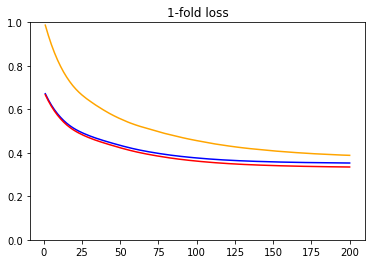

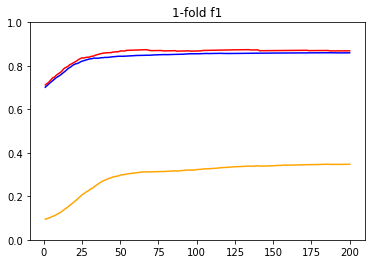

 20%|██        | 1/5 [19:24<1:17:37, 1164.32s/it]

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 13)                182       
                                                                 
 dense_1 (Dense)             (None, 16)                224       
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_2 (Dense)             (None, 2)                 34        
                                                                 
Total params: 440
Trainable params: 440
Non-trainable params: 0
_________________________________________________________________
epoch: 1
4071/4071 [==============================] - 3s 722us/step - loss: 5.7801 - accuracy: 0.6044
epoch: 2
4071/4071 [==============================] - 3s 750us/step - loss: 5.5386 - acc

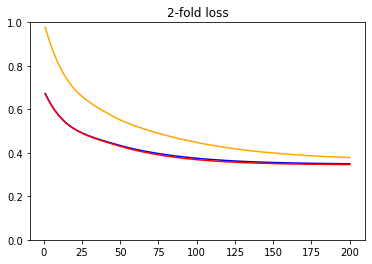

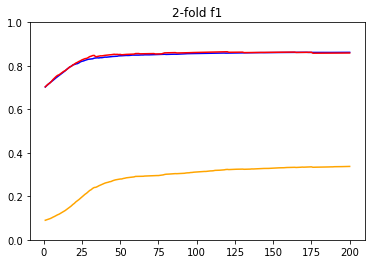

 40%|████      | 2/5 [38:40<57:58, 1159.41s/it]  

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 13)                182       
                                                                 
 dense_1 (Dense)             (None, 16)                224       
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_2 (Dense)             (None, 2)                 34        
                                                                 
Total params: 440
Trainable params: 440
Non-trainable params: 0
_________________________________________________________________
epoch: 1
4077/4077 [==============================] - 4s 906us/step - loss: 5.7797 - accuracy: 0.6038
epoch: 2
4077/4077 [==============================] - 4s 903us/step - loss: 5.5376 - acc

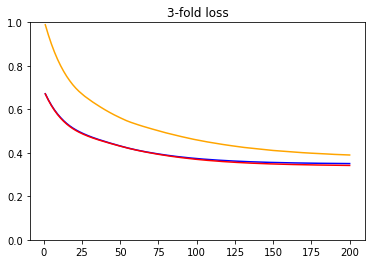

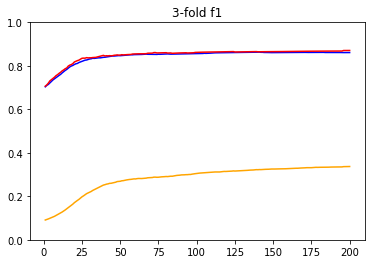

 60%|██████    | 3/5 [56:38<37:24, 1122.35s/it]

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 13)                182       
                                                                 
 dense_1 (Dense)             (None, 16)                224       
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_2 (Dense)             (None, 2)                 34        
                                                                 
Total params: 440
Trainable params: 440
Non-trainable params: 0
_________________________________________________________________
epoch: 1
4073/4073 [==============================] - 3s 767us/step - loss: 5.7800 - accuracy: 0.6064
epoch: 2
4073/4073 [==============================] - 3s 802us/step - loss: 5.5390 - acc

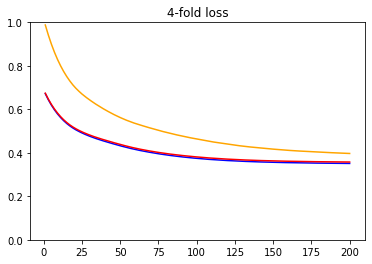

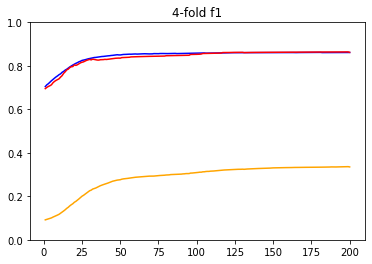

 80%|████████  | 4/5 [1:22:48<21:39, 1299.04s/it]

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 13)                182       
                                                                 
 dense_1 (Dense)             (None, 16)                224       
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_2 (Dense)             (None, 2)                 34        
                                                                 
Total params: 440
Trainable params: 440
Non-trainable params: 0
_________________________________________________________________
epoch: 1
4081/4081 [==============================] - 3s 738us/step - loss: 5.7812 - accuracy: 0.6022
epoch: 2
4081/4081 [==============================] - 3s 763us/step - loss: 5.5389 - acc

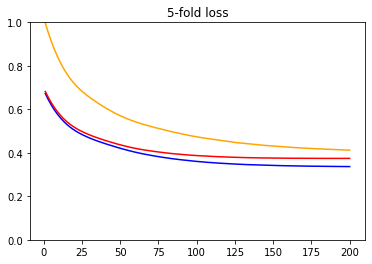

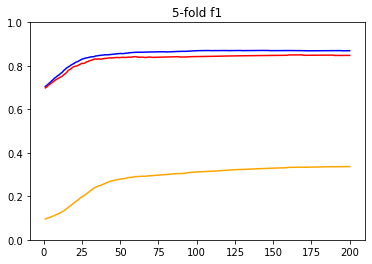

100%|██████████| 5/5 [1:54:06<00:00, 1369.37s/it]


,1_fold,2_fold,3_fold,4_fold,5_fold,average,min,max
0,0.671831,0.672721,0.671752,0.672149,0.672915,0.672274,0.671752,0.672915
1,0.657338,0.658213,0.657254,0.657586,0.658106,0.657699,0.657254,0.658213
2,0.643873,0.644596,0.643733,0.643972,0.644217,0.644078,0.643733,0.644596
3,0.631240,0.631904,0.631015,0.631233,0.631152,0.631309,0.631015,0.631904
4,0.619410,0.619914,0.619065,0.619320,0.618865,0.619315,0.618865,0.619914
...,...,...,...,...,...,...,...,...
195,0.353352,0.349826,0.350746,0.351450,0.336928,0.348461,0.336928,0.353352
196,0.353301,0.349771,0.350688,0.351382,0.336888,0.348406,0.336888,0.353301
197,0.353253,0.349705,0.350633,0.351321,0.336837,0.348350,0.336837,0.353253
198,0.353207,0.349643,0.350575,0.351262,0.336783,0.348294,0.336783,0.353207


auc_roc =  [0.9383802186670527, 0.9284094722748946, 0.938524580538489, 0.9302557178873291, 0.9219610383013309] auc_roc_up = [0.9388088164588535, 0.9287863665743263, 0.9385457289379469, 0.9286553822350618, 0.9219909128425368]


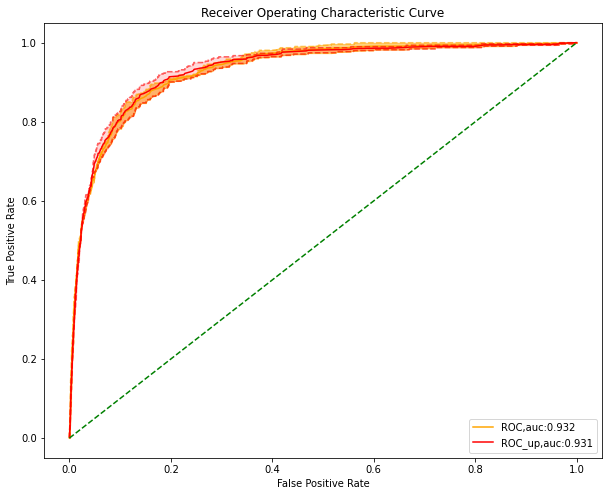

origin_best: 4 origin_min: 5
up_best: 3 up_min: 5


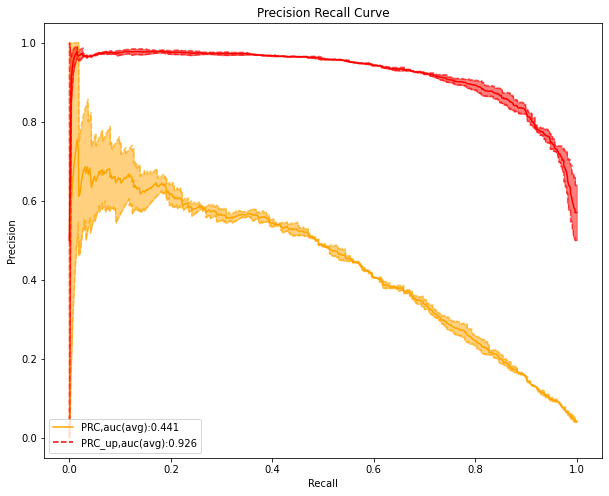

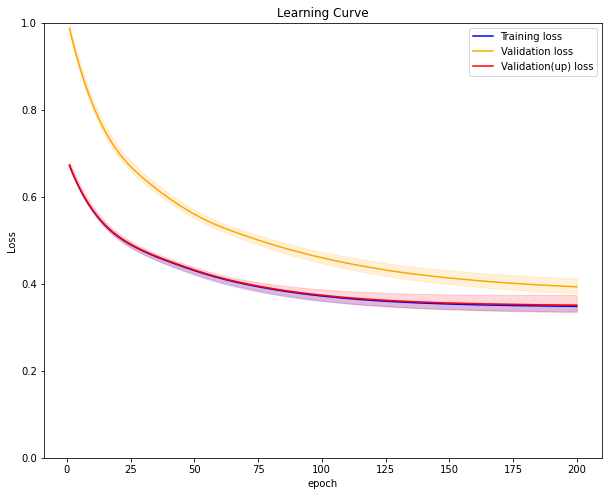

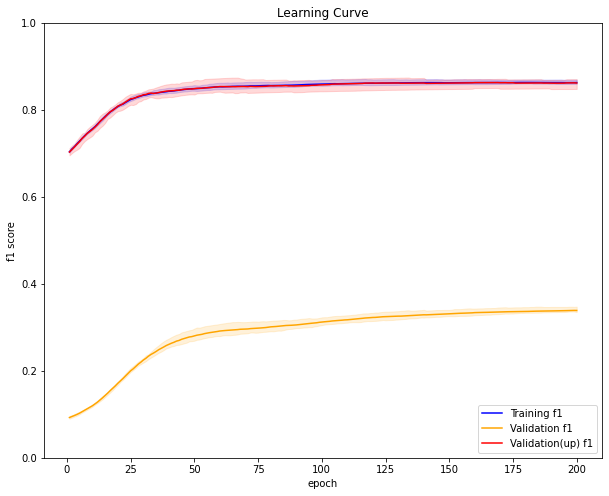

,1,2,3,4,5,average
f1,0.347607,0.337443,0.337065,0.335155,0.336704,0.338795
precision,0.218009,0.211039,0.209428,0.208617,0.211037,0.211626
recall,0.857143,0.841424,0.863057,0.851852,0.832353,0.849166
specificity,0.878602,0.881275,0.874263,0.871817,0.869479,0.875087


,1,2,3,4,5,average
f1,0.869033,0.859118,0.870723,0.862135,0.848093,0.861820
precision,0.876512,0.876477,0.873469,0.869598,0.864446,0.872101
recall,0.86168,0.842433,0.867994,0.854799,0.832346,0.851851
specificity,0.878602,0.881275,0.874263,0.871817,0.869479,0.875087


In [24]:
output = kfold_self(random_state=30,path = path,epoch=200,lr = 1.7e-6 ,model_save_path = model_save_path,gamma=3.5e-1,batch_size =16,python_random = 888,dropout=0.2)
display(output['score'])
display(output['score_up'])
output['score'].to_csv(f'{model_save_path}/{model_name}_spe_validation.csv')
output['score_up'].to_csv(f'{model_save_path}/{model_name}_score_up_spe_validation.csv')

f1_json = json.dumps(output['f1'])
with open(f'{model_save_path}/f1.json','w') as json_file:
    json_file.write(f1_json)


loss_json = json.dumps(output['loss'])
with open(f'{model_save_path}/loss.json','w') as json_file:
    json_file.write(loss_json)
roc_json = json.dumps(output['roc'])

with open(f'{model_save_path}/roc_validation.json','w') as json_file:
    json_file.write(roc_json)
prc_json = json.dumps(output['prc'])

with open(f'{model_save_path}/prc_validation.json','w') as json_file:
  json_file.write(prc_json)

### filter the data that is hard to work on

In [ ]:
def kfold_self_finding(
    lr = 0.1,
    random_state  = 30,
    path = 'k_fold_train_validation_42',
    epoch = 10,
    gamma = 0.001,
    batch_size = 256,
    python_random = 30,
    dropout=None,
    fold = 1,
    ):
    '''
    out_put -- the learning curve for average from k-fold or learning curve for each single fold
    cv : inter, default:5 -- input how many fold we want to do
    model:default: None -- input the training model 
    point_amount: inter,default:20 -- set the train_size(input as how many point want to be seperate by max length of training data)
    sub_plot :boolean,default:False  -- True if want to plot the learning curve for each fold
    loss_log: boolean,default:False -- True if want to get the loss log for each fold,
                                        False for the average loss for 
                                        -train
                                        -nonupsampling validation
                                        -upsampling validation
    plot :boolean,default:True --True if want to plot the learning for after average
    path: the folder for the datas
    '''

    ''' ==================================model set====================================='''
    # Define the model architecture

    '''=================================================================================='''
    test_loss = [[]]
    train_loss_up = [[]]
    test_loss_up = [[]]

    train_f1_total = []
    test_f1_total = []
    test_f1_up_total = []
    epoch_time = 0
    tf.keras.backend.clear_session()
    tf.random.set_seed(random_state)
    random.seed(python_random)
    initial_learning_rate = lr
    # lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    #     initial_learning_rate,
    #     decay_steps=100000,
    #     decay_rate=0.99,
    #     staircase=True)
    
    model = Sequential()
    model.add(Dense(units=13, input_dim=13, activation='relu' ,bias_initializer='glorot_uniform'))
    model.add(Dense(units=16, activation='relu', kernel_regularizer=l2(gamma),bias_initializer='glorot_uniform'))
    model.add(Dropout(dropout))
    model.add(Dense(units=2, activation='softmax',bias_initializer='glorot_uniform'))
    optimizer = Adam(learning_rate=initial_learning_rate)
    model.compile(loss='binary_crossentropy',optimizer = optimizer, metrics=['accuracy'])
    model.summary()

    '================================================================================'
    #print('fold',i)
    fold_train = pd.read_csv(path+'/{}-fold_train_z.csv'.format(fold))
    fold_test = pd.read_csv(path+'/{}-fold_test_z.csv'.format(fold))
    ##rename(消去columns項內非英文以及數字的解)
    try:
        fold_train = fold_train.drop(columns=['Unnamed: 0'])
        fold_test = fold_test.drop(columns=['Unnamed: 0'])
    except:
        pass
    fold_train = fold_train.rename(columns=lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
    fold_test = fold_test.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
    '==============================================================================='           
    ## upsampling train set 
    one_message = fold_train[fold_train["Class"] == 1 ]
    zero_message =fold_train[fold_train["Class"] == 0]
    one_message_up = resample(one_message,
                replace=True,
                n_samples=len(zero_message),
                random_state=42)
    fold_train = pd.concat([one_message_up,zero_message])
    ## fold_train = fold_train.sample(frac=1,axis = 0).reset_index(drop=True)
    fold_train = shuffle(fold_train,random_state = random_state)
    fold_train= fold_train.reset_index(drop = True)
    
    ## set the train set for single fold
    x_train = fold_train.drop(columns=['Class'])
    y_train = fold_train['Class']
    y_train_onehot = to_categorical(y_train, num_classes=2)
    
    ## set the non upsampling validation for the single fold       
    fold_test = shuffle(fold_test,random_state = random_state)
    fold_test = fold_test.reset_index(drop = True)
    x_test = fold_test.drop(columns=["Class"])
    y_test = fold_test['Class']
    y_test_onehot = to_categorical(y_test, num_classes=2) # convert to two dimensional
    '============================================================================'
    ## upsampling validation
    fold_test_up = pd.read_csv(path+'/{}-fold_test_z.csv'.format(fold))
    try:
        fold_test_up = fold_test_up.drop(columns=['Unnamed: 0'])
    except:
        pass
    fold_test_up = fold_test_up.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
    ## set the upsampling validation for single fold
    one_message_test = fold_test_up[fold_test_up["Class"] == 1 ]
    zero_message_test =fold_test_up[fold_test_up["Class"] == 0]
    one_message_test_up = resample(one_message_test,
                replace=True,
                n_samples=len(zero_message_test),
                random_state=42)  #其餘為使用42
    fold_test_up = pd.concat([one_message_test_up,zero_message_test])
    fold_test_up = shuffle(fold_test_up,random_state = random_state)
    fold_test_up = fold_test_up.reset_index(drop = True)
    x_test_up = fold_test_up.drop(columns=["Class"])
    y_test_up = fold_test_up['Class']
    y_test_up_onehot = to_categorical(y_test_up, num_classes=2) # convert to two dimensional
    '=================================================================================='
    train_loss = []
    val_loss =  []
    val_loss_up = []
    train_f1 = []
    val_f1 = []
    val_f1_up = []
    ## log train/validationS loss for non upsampling
    for time_epoch in range(epoch):
        epoch_time += 1
        print('epoch:',epoch_time)
        optimizer.lr.assign(lr_schedule(epoch_time, initial_learning_rate))
        history = model.fit(x_train, y_train_onehot, epochs=1, batch_size=batch_size, verbose=1,callbacks=[stop_training_callback])
        
        # Record training metrics
        
        # train_metrics = model.evaluate(x_train,y_train_onehot,verbose = 0)
        # train_loss.append(train_metrics[0])
        # # Evaluate and record validation metrics for validation set 1
        # val1_metrics = model.evaluate(x_test, y_test_onehot, verbose=0)
        # val_loss.append(val1_metrics[0])

        # # Evaluate and record validation metrics for validation set 2
        # val2_metrics = model.evaluate(x_test_up, y_test_up_onehot, verbose=0)
        # val_loss_up.append(val2_metrics[0])
        #
        '''=================for f1 & loss====================='''
        ## for training
        y_train_pred_prob_epoch = model.predict(x_train, verbose=0) # same as predict in skitlearn
        y_train_pred_prob_1_epoch  = [x[1] for x in y_train_pred_prob_epoch ] #將為KD的機率以0.5作為threshold 
        y_train_pred_epoch = [1 if x >=0.5 else 0 for x in y_train_pred_prob_1_epoch ]
        ## for training loss
        # BinaryCrossentropy
        train_loss_epoch = tf.keras.losses.BinaryCrossentropy()(y_train_onehot,y_train_pred_prob_epoch).numpy()
        train_loss.append(train_loss_epoch)

        ## for val 
        y_val_pred_prob_epoch = model.predict(x_test, verbose=0) # same as predict in skitlearn
        y_val_pred_prob_1_epoch = [x[1] for x in y_val_pred_prob_epoch] #將為KD的機率以0.5作為threshold
        y_val_pred_epoch = [1 if x >=0.5 else 0 for x in y_val_pred_prob_1_epoch ]
        ## for val loss
        val_loss_epoch = tf.keras.losses.BinaryCrossentropy()(y_test_onehot,y_val_pred_prob_epoch).numpy()
        val_loss.append(val_loss_epoch)
        ## for val up sample 
        y_val_pred_prob_up_epoch = model.predict(x_test_up, verbose=0) # same as predict in skitlearn
        y_val_pred_prob_1_up_epoch = [x[1] for x in y_val_pred_prob_up_epoch] #將為KD的機率以0.5作為threshold
        y_val_pred_up_epoch = [1 if x >=0.5 else 0 for x in y_val_pred_prob_1_up_epoch ]     
        ## for val up sample loss
        val_loss_up_epoch = tf.keras.losses.BinaryCrossentropy()(y_test_up_onehot,y_val_pred_prob_up_epoch).numpy()
        val_loss_up.append(val_loss_up_epoch)
        # print(train_loss_epoch,val_loss_up_epoch,val_loss_epoch)
        
        train_f1.append(f1_score(y_train_pred_epoch,y_train))
        val_f1.append(f1_score(y_val_pred_epoch,y_test))
        val_f1_up.append(f1_score(y_val_pred_up_epoch,y_test_up))


    '========================================================================================'
    plt.figure('learning curve single')
    plt.plot([i+1 for i in range(epoch)],train_loss,label='loss', color='blue')
    plt.plot([i+1 for i in range(epoch)],val_loss,label='val_loss', color='orange',linestyle='-')
    plt.plot([i+1 for i in range(epoch)],val_loss_up,label='val_loss_up', color='red')
    plt.ylim([0, 1])
    plt.title('{}-fold loss'.format(fold))
    plt.show()
    '======================================================================================='
    plt.figure('learning curve single(f1)')
    plt.plot([i+1 for i in range(epoch)],train_f1,label='f1', color='blue')
    plt.plot([i+1 for i in range(epoch)],val_f1,label='val_f1', color='orange',linestyle='-')
    plt.plot([i+1 for i in range(epoch)],val_f1_up,label='val_loss_f1', color='red')
    plt.ylim([0, 1])
    plt.title('{}-fold f1'.format(fold))
    plt.show()

    y_val_pred_prob_up_epoch = model.predict(x_test_up, verbose=0) # same as predict in skitlearn
    y_val_pred_prob_1_up_epoch = [x[1] for x in y_val_pred_prob_up_epoch] #將為KD的機率以0.5作為threshold
    y_val_pred_up_epoch = [1 if x >=0.5 else 0 for x in y_val_pred_prob_1_up_epoch ]   
    
    val_up_table = x_test_up.copy()
    val_up_table['y_true'] = y_test_up
    val_up_table['y_pred'] = y_val_pred_up_epoch
    return (val_up_table)
#         

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 13)                182       
                                                                 
 dense_1 (Dense)             (None, 16)                224       
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_2 (Dense)             (None, 2)                 34        
                                                                 
Total params: 440
Trainable params: 440
Non-trainable params: 0
_________________________________________________________________
epoch: 1
5082/5082 [==============================] - 4s 694us/step - loss: 0.7677 - accuracy: 0.4739
epoch: 2
5082/5082 [==============================] - 3s 669us/step - loss: 0.7519 - acc

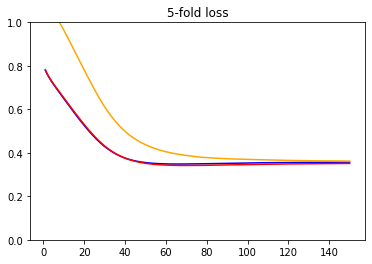

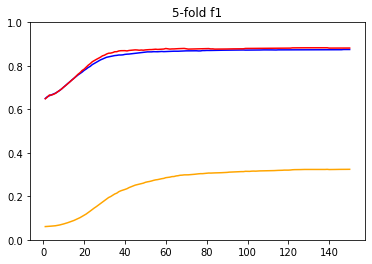

,agepmonthp,Platelets,HBpzpscore,WBCp1000p,Lymp,eosinophilp,monocytep,Bandp,Bandpcountp,Segp,Segpcountp,ALTpGPT,CRP,y_true,y_pred
0,-0.276656,1.318688,-2.738636,0.637318,0.040673,-0.614068,2.671031,-0.277115,-0.261237,-0.462405,0.102847,0.055172,4.469691,1,1
1,-0.738803,-0.062194,0.134021,-0.606555,0.743925,1.591146,-1.223635,-0.277115,-0.261237,-0.493755,-0.658951,-0.150705,0.849996,1,1
2,-0.809805,1.529656,-0.076923,3.292151,-0.939268,-0.614068,1.532980,-0.006107,0.349663,0.530341,2.963505,-0.099235,0.996485,1,0
3,-0.627229,-0.186856,-1.378947,-0.068163,1.821859,-0.435267,-0.186743,-0.277115,-0.261237,-1.517852,-0.804917,-0.227908,-0.619619,0,0
4,-0.793323,0.455637,-0.626374,0.043229,0.490293,-0.494867,-1.299505,-0.277115,-0.261237,-0.065307,-0.064291,0.042305,-0.640883,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20301,-0.720419,0.014522,0.546392,1.602712,0.011851,-0.316066,0.142027,0.264901,0.567687,-0.148906,0.955366,2.461357,0.076912,1,1
20302,2.429027,-0.263572,0.006803,-0.216685,-0.697165,-0.018064,-1.400665,-0.277115,-0.261237,0.990140,0.197540,-0.189307,-0.640883,0,0
20303,0.618476,-1.232107,-1.054348,-1.330601,0.271247,-0.435267,-0.060293,-0.277115,-0.261237,-0.138456,-1.036929,-0.189307,-0.624344,0,0
20304,-0.192341,1.894055,-0.465909,-0.866469,1.718101,0.220337,-0.970734,-0.277115,-0.261237,-1.319302,-1.031881,-0.150705,-0.610168,1,0


In [25]:
path = 'D:/CODE/KD/code_after_web/data/lam/k-fold_z/7414' 
model_name = 'NN_7414 random_seed - 20 lr 1.5e-6 batch_size 16 dropout 0.1 decay_rate 0.99 gamma 9e-5'
# model_save_path = f'D:/CODE/KD/code_after_web/output/lam/{model_name}'
# if os.path.exists(model_save_path) == False:
#     os.mkdir(model_save_path)
output = kfold_self_finding(random_state=30,path = path,epoch=150,lr = 1.5e-6 ,gamma=9e-5,batch_size =16,python_random = 20,dropout=0.1,fold=5)
output

In [26]:
output.to_csv(f'D:/CODE/KD/code_after_web/output/lam/{model_name}/fold5.csv',index=False)

In [27]:
output_filter = output[(output['y_true'] != output["y_pred"])]
output_filter.to_csv(f'D:/CODE/KD/code_after_web/output/lam/{model_name}/fold5-filter.csv',index=False)


In [28]:
output_filter_group = output_filter.groupby(output_filter.columns.tolist(),as_index=False).size()
output_filter_group.sort_values(by=['size'],inplace=True,ascending=False)
output_filter_group.to_csv(f'D:/CODE/KD/code_after_web/output/lam/{model_name}/fold5-filter-group.csv',index=False)

## test
注意不可同training執行

In [3]:
def kfold_self_test(
    random_state  = 30,
    path = 'k_fold_train_validation_42',
    model_save_path = None,
    fold = 4,
    ):
    '''
    out_put -- the learning curve for average from k-fold or learning curve for each single fold
    cv : inter, default:5 -- input how many fold we want to do
    model:default: None -- input the training model 
    point_amount: inter,default:20 -- set the train_size(input as how many point want to be seperate by max length of training data)
    sub_plot :boolean,default:False  -- True if want to plot the learning curve for each fold
    loss_log: boolean,default:False -- True if want to get the loss log for each fold,
                                        False for the average loss for 
                                        -train
                                        -nonupsampling validation
                                        -upsampling validation
    plot :boolean,default:True --True if want to plot the learning for after average
    path: the folder for the datas
    '''

    ''' ==================================model set====================================='''
    # Define the model architecture

    '''=================================================================================='''

    f1 = []
    recall =[]
    precision=[]
    specificity =[]


    tf.keras.backend.clear_session()
    '================================================================================'
    #print('fold',i)
    fold_test = pd.read_csv(path+'/total-test_z-fold{}.csv'.format(fold))
    ##rename(消去columns項內非英文以及數字的解)
    try:
        fold_test = fold_test.drop(columns=['Unnamed: 0'])
    except:
        pass
    fold_test = fold_test.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
    '==============================================================================='           
    ## set the non upsampling validation for the single fold       
    fold_test = shuffle(fold_test,random_state = random_state)
    fold_test = fold_test.reset_index(drop = True)
    x_test = fold_test.drop(columns=["Class"])
    y_test = fold_test['Class']
    '============================================================================'
    

    ## log train/validationS loss for non upsampling
    model = tf.keras.models.load_model(f"{model_save_path}/{fold}-model")
    '==================================================================================='

    y_val_pred_prob = model.predict(x_test) # same as predict in skitlearn
    y_val_pred_prob_1 = [x[1] for x in y_val_pred_prob] #將為KD的機率以0.5作為threshold
    y_val_pred = [1 if x >=0.5 else 0 for x in y_val_pred_prob_1 ]
 
    '===========================================roc====================================='
    fper_i , tper_i , threshold = roc_curve(y_test,y_val_pred_prob_1, pos_label=1)
    auc_roc= (roc_auc_score(y_test,y_val_pred_prob_1))
    plt.figure(figsize=(10, 8))
    plt.plot(fper_i,tper_i,color = 'orange',linestyle='-',alpha=1)
    plt.plot(1,1,color='orange',label='%.3f'%(auc_roc))
    plt.plot([0,1],[0,1],color = 'green',linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend()
    plt.legend(loc='lower right')  
    plt.show()    
    roc_data = {
                    'fper':list(fper_i),
                    'tper':list(tper_i),
                    'auc':auc_roc,
                    }
    
    '=====================================precision========================================='
    precision_i , recall_i , threshold = precision_recall_curve(y_test,y_val_pred_prob_1, pos_label=1)
    auc_list = (auc(recall_i,precision_i))
    plt.figure(figsize=(10, 8))
    plt.plot(recall_i[0:len(recall_i)-15][::-1],precision_i[0:len(precision_i)-15][::-1],color = 'orange',linestyle='-',alpha=1)
    plt.plot(1,1,color = 'orange',label='%.3f'%(auc_list),linestyle='-')
    prc_curve_data = {
            'precision':list(precision_i),
            'recall':list(recall_i),
            'auc':auc_list,
                }
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision Recall Curve')
    plt.legend()
    plt.legend(loc='lower left')
    plt.show()
    '=====================================score============================================'
    #train_f1 = f1_score(y_train, y_train_pred)
    f1.append(f1_score(y_test, y_val_pred))
    specificity.append(recall_score(y_test, y_val_pred, pos_label=0))
    recall.append(recall_score(y_test, y_val_pred, pos_label=1))
    precision.append(precision_score(y_test, y_val_pred))



# ## compute the average loss for the learning curve
    score = pd.DataFrame(columns=['1'],index=['f1','precision','recall','specificity'])
    score.loc['f1'] = f1
    score.loc['precision'] = precision
    score.loc['recall'] = recall
    score.loc['specificity'] = specificity
    
    return({'score':score,'roc':roc_data,'prc':prc_curve_data})

In [6]:
path = 'D:/CODE/KD/code_after_web/data/lam_under7(ByKeptGPT,with monocyte count)/k-fold/30' 
model_name = "NN30random_seed - 888 lr 1.7e-6 dropout 0.2 decay_rate 0.99 gamma 3.5e-1"
model_save_path = f'D:/CODE/KD/code_after_web/output/Under 7/lam_under7(ByKeptGPT,with monocyte count)/{model_name}'

147/147 [==============================] - 1s 508us/step


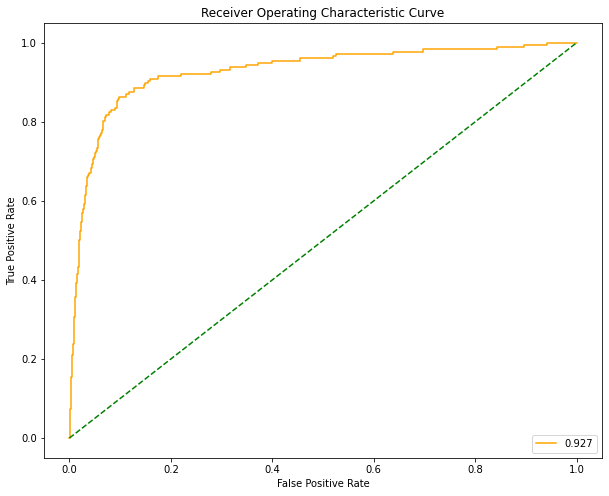

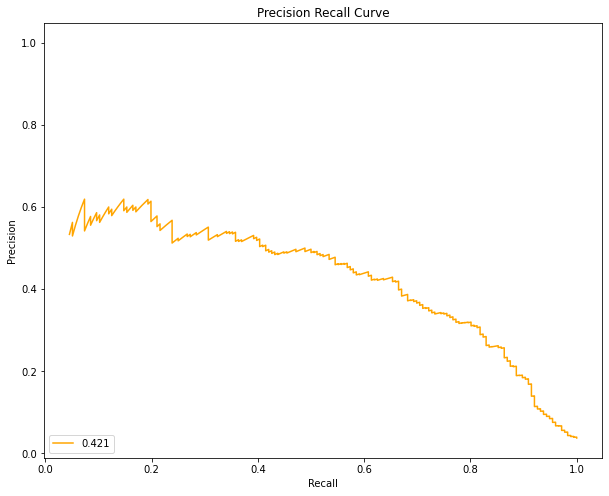

,1
f1,0.333333
precision,0.205263
recall,0.886364
specificity,0.866431


In [7]:
output = kfold_self_test(random_state=30,path = path,fold=4,model_save_path=model_save_path)
output['score']

In [16]:
output['score'].to_csv("D:/CODE/KD/code_after_web/output/Under 7/lam_under7(ByKeptGPT,with monocyte count)/NN30random_seed - 888 lr 1.7e-6 dropout 0.2 decay_rate 0.99 gamma 3.5e-1/test_score.csv")

In [9]:
prc_json = json.dumps(output['prc'])
with open(f'{model_save_path}/prc_test.json','w') as json_file:
    json_file.write(prc_json)

In [10]:
roc_json = json.dumps(output['roc'])
with open(f'{model_save_path}/roc_test.json','w') as json_file:
    json_file.write(roc_json)

In [30]:
# prc_test_json = json.dumps(output['prc'])
# with open(f'{model_save_path}/prc_test.json','w') as json_file:
#        json_file.write(prc_test_json)

roc_test_json = json.dumps(output['roc'])
with open(f'{model_save_path}/roc_test.json','w') as json_file:
       json_file.write(roc_test_json)

## Over sample with likelihood

In [4]:
def kfold_self_oversample(
    random_state  = 30,
    path = 'k_fold_train_validation_42',
    model_save_path = None,
    cv = 5,
    ):
    '''
    out_put -- the learning curve for average from k-fold or learning curve for each single fold
    cv : inter, default:5 -- input how many fold we want to do
    model:default: None -- input the training model 
    point_amount: inter,default:20 -- set the train_size(input as how many point want to be seperate by max length of training data)
    sub_plot :boolean,default:False  -- True if want to plot the learning curve for each fold
    loss_log: boolean,default:False -- True if want to get the loss log for each fold,
                                        False for the average loss for 
                                        -train
                                        -nonupsampling validation
                                        -upsampling validation
    plot :boolean,default:True --True if want to plot the learning for after average
    path: the folder for the datas
    '''

    ''' ==================================model set====================================='''
    # Define the model architecture

    '''=================================================================================='''

    f1 = []
    recall = []
    precision = []
    specificity = []
    positive = []
    negative = []

    tf.keras.backend.clear_session()
    '================================================================================'
    for i in range(1,cv+1):
        ## upsampling validation
        fold_test_up = pd.read_csv(path+'/{}-fold_test_z.csv'.format(i))
        try:
            fold_test_up = fold_test_up.drop(columns=['Unnamed: 0'])
        except:
            pass
        fold_test_up = fold_test_up.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
        ## set the upsampling validation for single fold
        one_message_test = fold_test_up[fold_test_up["Class"] == 1 ]
        zero_message_test =fold_test_up[fold_test_up["Class"] == 0]
        one_message_test_up = resample(one_message_test,
                    replace=True,
                    n_samples=len(zero_message_test),
                    random_state=42)  #其餘為使用42
        fold_test_up = pd.concat([one_message_test_up,zero_message_test])
        fold_test_up = shuffle(fold_test_up,random_state = random_state)
        fold_test_up = fold_test_up.reset_index(drop = True)
        x_test_up = fold_test_up.drop(columns=["Class"])
        y_test_up = fold_test_up['Class']
        y_test_up_onehot = to_categorical(y_test_up, num_classes=2) # convert to two dimensional
        '============================================================================'


        ## log train/validationS loss for non upsampling
        model = tf.keras.models.load_model(f"{model_save_path}/{i}-model")
        '==================================================================================='

        y_val_pred_prob = model.predict(x_test_up) # same as predict in skitlearn
        y_val_pred_prob_1 = [x[1] for x in y_val_pred_prob] #將為KD的機率以0.5作為threshold
        y_val_pred = [1 if x >=0.5 else 0 for x in y_val_pred_prob_1 ]
    

        '=====================================score============================================'
        #train_f1 = f1_score(y_train, y_train_pred)
        f1.append(f1_score(y_test_up, y_val_pred))
        specificity.append(recall_score(y_test_up, y_val_pred, pos_label=0))
        recall.append(recall_score(y_test_up, y_val_pred, pos_label=1))
        precision.append(precision_score(y_test_up, y_val_pred))
        positive.append(class_likelihood_ratios(y_test_up,y_val_pred)[0])
        negative.append(class_likelihood_ratios(y_test_up,y_val_pred)[1])

# ## compute the average loss for the learning curve
    score = pd.DataFrame(columns=['1','2','3','4','5'],index=['f1','precision','recall','specificity','positive likelihood','negative likelihood'])
    score.loc['f1'] = f1
    score.loc['precision'] = precision
    score.loc['recall'] = recall
    score.loc['specificity'] = specificity
    score.loc['positive likelihood'] = positive
    score.loc['negative likelihood'] = negative
    score['average'] = score.sum(axis = 1)/cv
    return score

In [6]:
path = 'D:/CODE/KD/code_after_web/data/lam_under7(ByKeptGPT,with monocyte count)/k-fold/30' 
model_name = "NN30random_seed - 888 lr 1.7e-6 dropout 0.2 decay_rate 0.99 gamma 3.5e-1"
model_save_path = f'D:/CODE/KD/code_after_web/output/Under 7/lam_under7(ByKeptGPT,with monocyte count)/{model_name}'
score_up = kfold_self_oversample(random_state  = 30,path = path,model_save_path = model_save_path)
score_up.to_csv(f"{model_save_path}/score_up_validation_likelihood.csv")
print(score_up)

507/507 [==============================] - 0s 452us/step
                            1         2         3         4         5  \
f1                   0.869033  0.859118  0.870723  0.862135  0.848093   
precision            0.876512  0.876477  0.873469  0.869598  0.864446   
recall                0.86168  0.842433  0.867994  0.854799  0.832346   
specificity          0.878602  0.881275  0.874263  0.871817  0.869479   
positive likelihood   7.09798  7.095679  6.903226  6.668577  6.377127   
negative likelihood  0.157432  0.178794  0.150991   0.16655  0.192821   

                      average  
f1                   0.861820  
precision            0.872101  
recall               0.851851  
specificity          0.875087  
positive likelihood  6.828518  
negative likelihood  0.169318  


## Origin with likelihood

In [7]:
def kfold_self_origin(
    random_state  = 30,
    path = 'k_fold_train_validation_42',
    model_save_path = None,
    cv = 5,
    ):
    '''
    out_put -- the learning curve for average from k-fold or learning curve for each single fold
    cv : inter, default:5 -- input how many fold we want to do
    model:default: None -- input the training model 
    point_amount: inter,default:20 -- set the train_size(input as how many point want to be seperate by max length of training data)
    sub_plot :boolean,default:False  -- True if want to plot the learning curve for each fold
    loss_log: boolean,default:False -- True if want to get the loss log for each fold,
                                        False for the average loss for 
                                        -train
                                        -nonupsampling validation
                                        -upsampling validation
    plot :boolean,default:True --True if want to plot the learning for after average
    path: the folder for the datas
    '''

    ''' ==================================model set====================================='''
    # Define the model architecture

    '''=================================================================================='''

    f1 = []
    recall = []
    precision = []
    specificity = []
    positive = []
    negative = []

    tf.keras.backend.clear_session()
    '================================================================================'
    for i in range(1,cv+1):
        ## upsampling validation
        fold_test = pd.read_csv(path+'/{}-fold_test_z.csv'.format(i))
        try:
            fold_test = fold_test.drop(columns=['Unnamed: 0'])
        except:
            pass
        fold_test = fold_test.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

        fold_test = shuffle(fold_test,random_state = random_state)
        fold_test = fold_test.reset_index(drop = True)
        x_test = fold_test.drop(columns=["Class"])
        y_test = fold_test['Class']
        y_test_up_onehot = to_categorical(y_test, num_classes=2) # convert to two dimensional
        '============================================================================'


        ## log train/validationS loss for non upsampling
        model = tf.keras.models.load_model(f"{model_save_path}/{i}-model")
        '==================================================================================='

        y_val_pred_prob = model.predict(x_test) # same as predict in skitlearn
        y_val_pred_prob_1 = [x[1] for x in y_val_pred_prob] #將為KD的機率以0.5作為threshold
        y_val_pred = [1 if x >=0.5 else 0 for x in y_val_pred_prob_1 ]
    

        '=====================================score============================================'
        #train_f1 = f1_score(y_train, y_train_pred)
        f1.append(f1_score(y_test, y_val_pred))
        specificity.append(recall_score(y_test, y_val_pred, pos_label=0))
        recall.append(recall_score(y_test, y_val_pred, pos_label=1))
        precision.append(precision_score(y_test, y_val_pred))
        positive.append(class_likelihood_ratios(y_test,y_val_pred)[1])
        negative.append(class_likelihood_ratios(y_test,y_val_pred)[0])

# ## compute the average loss for the learning curve
    score = pd.DataFrame(columns=['1','2','3','4','5'],index=['f1','precision','recall','specificity','positive likelihood','negative likelihood'])
    score.loc['f1'] = f1
    score.loc['precision'] = precision
    score.loc['recall'] = recall
    score.loc['specificity'] = specificity
    score.loc['positive likelihood'] = positive
    score.loc['negative likelihood'] = negative
    score['average'] = score.sum(axis = 1)/cv
    return score

In [8]:
path = 'D:/CODE/KD/code_after_web/data/lam_under7(ByKeptGPT,with monocyte count)/k-fold/30' 
model_name = "NN30random_seed - 888 lr 1.7e-6 dropout 0.2 decay_rate 0.99 gamma 3.5e-1"
model_save_path = f'D:/CODE/KD/code_after_web/output/Under 7/lam_under7(ByKeptGPT,with monocyte count)/{model_name}'
score = kfold_self_origin(random_state  = 30,path = path,model_save_path = model_save_path)
score.to_csv(f"{model_save_path}/score_validation_likelihood.csv")
print(score)

264/264 [==============================] - 0s 424us/step
                            1         2         3         4         5  \
f1                   0.347607  0.337443  0.337065  0.335155  0.336704   
precision            0.218009  0.211039  0.209428  0.208617  0.211037   
recall               0.857143  0.841424  0.863057  0.851852  0.832353   
specificity          0.878602  0.881275  0.874263  0.871817  0.869479   
positive likelihood  0.162596  0.179939  0.156638   0.16993  0.192813   
negative likelihood  7.060606  7.087179  6.863963  6.645584  6.377177   

                      average  
f1                   0.338795  
precision            0.211626  
recall               0.849166  
specificity          0.875087  
positive likelihood  0.172383  
negative likelihood  6.806902  


In [9]:
def kfold_self_test_likelihood(
    random_state  = 30,
    path = 'k_fold_train_validation_42',
    model_save_path = None,
    fold = 4,
    ):
    '''
    out_put -- the learning curve for average from k-fold or learning curve for each single fold
    cv : inter, default:5 -- input how many fold we want to do
    model:default: None -- input the training model 
    point_amount: inter,default:20 -- set the train_size(input as how many point want to be seperate by max length of training data)
    sub_plot :boolean,default:False  -- True if want to plot the learning curve for each fold
    loss_log: boolean,default:False -- True if want to get the loss log for each fold,
                                        False for the average loss for 
                                        -train
                                        -nonupsampling validation
                                        -upsampling validation
    plot :boolean,default:True --True if want to plot the learning for after average
    path: the folder for the datas
    '''

    ''' ==================================model set====================================='''
    # Define the model architecture

    '''=================================================================================='''

    f1 = []
    recall = []
    precision = []
    specificity = []
    positive = []
    negative = []

    tf.keras.backend.clear_session()
    '================================================================================'
    #print('fold',i)
    fold_test = pd.read_csv(path+'/total-test_z-fold{}.csv'.format(fold))
    ##rename(消去columns項內非英文以及數字的解)
    try:
        fold_test = fold_test.drop(columns=['Unnamed: 0'])
    except:
        pass
    fold_test = fold_test.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
    '==============================================================================='           
    ## set the non upsampling validation for the single fold       
    fold_test = shuffle(fold_test,random_state = random_state)
    fold_test = fold_test.reset_index(drop = True)
    x_test = fold_test.drop(columns=["Class"])
    y_test = fold_test['Class']
    '============================================================================'
    

    ## log train/validationS loss for non upsampling
    model = tf.keras.models.load_model(f"{model_save_path}/{fold}-model")
    '==================================================================================='

    y_val_pred_prob = model.predict(x_test) # same as predict in skitlearn
    y_val_pred_prob_1 = [x[1] for x in y_val_pred_prob] #將為KD的機率以0.5作為threshold
    y_val_pred = [1 if x >=0.5 else 0 for x in y_val_pred_prob_1 ]
 
    '=====================================score============================================'
    #train_f1 = f1_score(y_train, y_train_pred)
    f1.append(f1_score(y_test, y_val_pred))
    specificity.append(recall_score(y_test, y_val_pred, pos_label=0))
    recall.append(recall_score(y_test, y_val_pred, pos_label=1))
    precision.append(precision_score(y_test, y_val_pred))
    positive.append(class_likelihood_ratios(y_test,y_val_pred)[0])
    negative.append(class_likelihood_ratios(y_test,y_val_pred)[1])


# ## compute the average loss for the learning curve
    score = pd.DataFrame(columns=['1'],index=['f1','precision','recall','specificity'])
    score.loc['f1'] = f1
    score.loc['precision'] = precision
    score.loc['recall'] = recall
    score.loc['specificity'] = specificity
    score.loc['positive likelihood'] = positive
    score.loc['negative likelihood'] = negative
    return(score)

In [12]:
path = 'D:/CODE/KD/code_after_web/data/lam_under7(ByKeptGPT,with monocyte count)/k-fold/30' 
model_name = "NN30random_seed - 888 lr 1.7e-6 dropout 0.2 decay_rate 0.99 gamma 3.5e-1"
model_save_path = f'D:/CODE/KD/code_after_web/output/Under 7/lam_under7(ByKeptGPT,with monocyte count)/{model_name}'
score_test = kfold_self_test_likelihood(random_state  = 30,path = path,model_save_path = model_save_path,fold=4)
score_test.to_csv(f"{model_save_path}/test_score_likelihood.csv")
score_test

147/147 [==============================] - 0s 502us/step


,1
f1,0.333333
precision,0.205263
recall,0.886364
specificity,0.866431
positive likelihood,6.635987
negative likelihood,0.131155
